In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'XLA_GPU']

In [3]:
# get_available_gpus()

In [4]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from keras.layers import (
    Conv2D, BatchNormalization, Dense, 
    ZeroPadding2D, Activation, GlobalAveragePooling2D,
    Reshape, Permute, multiply, AveragePooling2D,
    UpSampling2D, Concatenate, Add, Lambda, Multiply
)
from keras.models import Model, Sequential
from keras.layers import Input
import keras.backend as K
from keras.layers import DepthwiseConv2D, PReLU

Using TensorFlow backend.


In [5]:
import cv2
# import imutils

In [6]:
from glob import glob
import pandas as pd
from sklearn.utils import shuffle
import imgaug as ia
from imgaug import augmenters as iaa

In [7]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, BaseLogger
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [8]:
from keras import __version__
print(__version__)

2.3.1


In [9]:
import tensorflow as tf
tf.__version__
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6299435178257513987
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7882634043176390859
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9770369024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4828738362653828509
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 445981844416826466
physical_device_desc: "device: XLA_GPU device"
]


In [11]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Constant Variables

In [12]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNEL = 3
CLASSES = ["Background", "Person"]
N_CLASSES = 2
IMAGE_DATA_FORMAT = K.image_data_format()

## Building model

In [13]:
class SiNet:
    def __init__(self, img_height, img_width, img_channel, n_classes, reg=1e-4):
        self.img_height = img_height
        self.img_width = img_width
        self.img_channel = img_channel
        self.n_classes = n_classes
        self.reg = reg
        self.channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        self.alpha = 1.0
        self.image_val = 0.017
        self.mean_substraction = [103.94, 116.78, 123.68]
        
    def relu6(self, x):
        return K.relu(x, max_value=6)
    
    def _conv_block(self, inputs, filters, alpha, strides=(1,1), kernel=(3,3), block_id=1, padding="valid"):
        """"""
        filters = int(filters * alpha)
        
        if padding=="same":
            x = inputs
        else:
            x = ZeroPadding2D((1, 1), data_format=IMAGE_DATA_FORMAT, 
                              name="conv_%s_pad" % block_id)(inputs)        
        
        x = Conv2D(filters, kernel, data_format=IMAGE_DATA_FORMAT, 
                   padding=padding, use_bias=False, strides=strides, 
                   kernel_initializer="he_normal", name="conv_%s" % block_id)(x)
        x = BatchNormalization(axis=self.channel_axis, name="conv_%s_bn" % block_id)(x)
        x = Activation("relu", name="conv_%s_act" % block_id)(x)
        
        return x
    
    def _pointwise_conv_block(self, inputs, pointwise_conv_filters, alpha, 
                              strides=(1, 1), block_id=1):
        x = Conv2D(pointwise_conv_filters, 
                   (1, 1),
                   data_format=IMAGE_DATA_FORMAT,
                   padding="same",
                   use_bias=False,
                   strides=(1, 1),
                   kernel_initializer="he_normal",
                   name="conv_pw_%s" % block_id)(inputs)
        x = BatchNormalization(axis=self.channel_axis,
                               name="conv_pw_%s_bn" % block_id)(x)
        x = Activation("relu", name="conv_pw_%s_relu" % block_id)(x)
        
        return x
        
    def _depthwise_conv_block(self, inputs, pointwise_conv_filters, alpha, 
                              depth_multiplier=1, strides=(1, 1), block_id=1, 
                              kernel=(3,3), padding_size=(1, 1)):
        """"""
        pointwise_conv_filters = int(pointwise_conv_filters * alpha)
        
        x = ZeroPadding2D(padding_size, 
                          data_format=IMAGE_DATA_FORMAT,
                          name="conv_pad_%s" % block_id)(inputs)
        x = DepthwiseConv2D(kernel_size=kernel,
                            data_format=IMAGE_DATA_FORMAT,
                            depth_multiplier=depth_multiplier,
                            strides=strides,
                            use_bias=False,
                            name="conv_dw_%s" % block_id)(x)
        x = BatchNormalization(axis=self.channel_axis,
                               name="conv_dw_%s_bn" % block_id)(x)
#         x = Activation("PReLu", name="conv_dw_%d_Prelu" % block_id)(x)
        x = PReLU(name="conv_dw_%s_Prelu" % block_id)(x)
        
        x = self._pointwise_conv_block(x, pointwise_conv_filters, self.alpha, block_id=block_id)
        
        return x
    
    def _squeeze_excite_block(self, inputs, ratio=16, block_id=1):
        """"""
        filters = inputs.shape[self.channel_axis]
        se_shape = (1, 1, filters) if self.channel_axis == -1 else (filters, 1, 1)
        
        se = GlobalAveragePooling2D(name="squeeze_glo_avg_%s" % block_id)(inputs)
        se = Dense(filters // ratio, activation="relu", 
                   kernel_initializer="he_normal", 
                   use_bias=False, name="squeeze_squ_%s" % block_id)(se)
        se = Dense(filters, activation="relu", kernel_initializer="he_normal", 
                   use_bias=False, name="squeeze_exci_%s" % block_id)(se)
        se = multiply([inputs, se], name="squeeze_scale_%s" % block_id)
        
        return se
    
    def _depthwise_conv_se_block(self, inputs, pointwise_conv_filters, alpha, 
                                 depth_multiplier=1, strides=(2, 2), block_id=1,
                                 kernel=(3,3), ratio=16):
        """
        DS-Conv + SE
        """
        x = self._depthwise_conv_block(inputs, pointwise_conv_filters, alpha, 
                                       block_id=block_id, strides=strides)
#         x = Activation("relu")(x)
        x = self._squeeze_excite_block(x, ratio=ratio, block_id=block_id)
        x = Activation("relu")(x)
        
        return x
    
    def _s2_block(self, inputs, pointwise_conv_filters, alpha, 
                  depth_multiplier=1, strides=(1, 1), block_id=1,
                  kernel=(3,3), pool_size=(1,1), padding_size=(1, 1)):
        x = AveragePooling2D(pool_size=pool_size, strides=(2, 2), 
                             data_format=IMAGE_DATA_FORMAT, padding="same")(inputs)
        x = Activation("relu")(x)
        x = self._depthwise_conv_block(x, pointwise_conv_filters, alpha, 
                                       block_id=block_id, kernel=kernel, 
                                       padding_size=padding_size)
        x = UpSampling2D(size=(2, 2), interpolation="bilinear", name="s2_block_%s" % block_id)(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation("relu")(x)
        
        return x
    
    def _s2_module(self, inputs, pointwise_conv_filters, alpha,
                   depth_multiplier=1, strides=(1, 1), block_id=1,
                   kernel_conv=(3, 3), kernel_ds_1=(3, 3), 
                   kernel_ds_2=(3, 3), pad_ds_1=(1, 1), pad_ds_2=(1, 1),
                   pool_block_1=(1, 1), pool_block_2=(1, 1)):
        """
        The function to build S2 block
        """
        x = self._conv_block(inputs, pointwise_conv_filters, alpha, 
                             kernel=(1, 1), block_id=block_id, padding="same")
        x1 = self._s2_block(x, pointwise_conv_filters, alpha, depth_multiplier=depth_multiplier,
                            strides=strides, kernel=kernel_ds_1, block_id=str(block_id) + "_1",
                            padding_size=pad_ds_1, pool_size=pool_block_1)
    
        x2 = self._s2_block(x, pointwise_conv_filters, alpha, depth_multiplier=depth_multiplier,
                            strides=strides, kernel=kernel_ds_2, block_id=str(block_id) + "_2", 
                            padding_size=pad_ds_2, pool_size=pool_block_2)
        
        x = Concatenate(axis=self.channel_axis)([x1, x2])
        x = Add()([inputs, x])
#         x = BatchNormalization(axis=self.channel_axis)(x)
        x = PReLU()(x)
        
        return x
    
    def build_encoder(self):
        """
        Build encoder function
        """
        
        input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)
        
        if IMAGE_DATA_FORMAT == "channels_first":
            input_shape = (IMG_CHANNEL, IMG_HEIGHT, IMG_WIDTH)
            
        inputs = Input(shape=input_shape)
        
        x = Lambda(lambda z: z[...,::-1], output_shape=input_shape, 
                   name="swap_color_channel")(inputs)
        
        if self.mean_substraction:
            x = Lambda(lambda z: (z - np.array(self.mean_substraction))*self.image_val,
                       output_shape=input_shape,
                       name="mean_substraction_inputs")(x)
#         x = inputs

        x1 = self._conv_block(x, 12, self.alpha, strides=(2, 2), block_id=1)
        x2 = self._depthwise_conv_se_block(x1, 16, self.alpha, block_id=2)
        x3 = self._depthwise_conv_se_block(x2, 48, self.alpha, block_id=3, strides=(1, 1))
        x4 = self._s2_module(x3, 24, self.alpha, block_id=4, kernel_ds_2=(5, 5), pad_ds_2=(2, 2))
        x5 = self._s2_module(x4, 24, self.alpha, block_id=5)
        
        x6 = Concatenate(axis=self.channel_axis, name="concat_2_5")([x2, x5])
        
        x7 = self._depthwise_conv_se_block(x6, 48, self.alpha, block_id=6)
        x8 = self._depthwise_conv_se_block(x7, 96, self.alpha, block_id=7, strides=(1, 1))
        x9 = self._s2_module(x8, 48, self.alpha, block_id=8, kernel_ds_2=(5, 5), pad_ds_2=(2, 2))
        x10 = self._s2_module(x9, 48, self.alpha, block_id=9)
        x11 = self._s2_module(x10, 48, self.alpha, block_id=10, 
                              kernel_ds_1=(5, 5), pad_ds_1=(2, 2),
                              kernel_ds_2=(3, 3), pool_block_2=(2, 2))
        x12 = self._s2_module(x11, 48, self.alpha, block_id=11,
                              kernel_ds_1=(5, 5), pad_ds_1=(2, 2),
                              kernel_ds_2=(3, 3), pool_block_2=(4, 4))
        x13 = self._s2_module(x12, 48, self.alpha, block_id=12)
        x14 = self._s2_module(x13, 48, self.alpha, block_id=13,
                              kernel_ds_1=(5, 5), pad_ds_1=(2, 2),
                              kernel_ds_2=(5, 5), pad_ds_2=(2, 2))
        x15 = self._s2_module(x14, 48, self.alpha, block_id=14,
                              kernel_ds_1=(3, 3), pool_block_1=(2, 2),
                              kernel_ds_2=(3, 3), pool_block_2=(4, 4))
        x16 = self._s2_module(x15, 48, self.alpha, block_id=15,
                              kernel_ds_1=(3, 3), pool_block_1=(1, 1),
                              kernel_ds_2=(5, 5), pad_ds_2=(2, 2), pool_block_2=(2, 2))
        
        x17 = Concatenate(axis=self.channel_axis, name="concat_16_7")([x16, x7])
        x17 = Activation("relu")(x17)
        
        x = self._pointwise_conv_block(x17, N_CLASSES, self.alpha, block_id=16)
#         x = Activation("relu")(x)
        
#         x = Reshape((-1, self.n_classes))(x)
        
#         x = Activation("softmax")(x)
        
#         model = Model(inputs=inputs, outputs=x)
        
        return inputs, x, x1, x2
    
    def build_decoder(self):
        inputs, x, x1, x2 = self.build_encoder()
        
        x = UpSampling2D((2, 2), data_format=IMAGE_DATA_FORMAT, 
                         interpolation="bilinear")(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x_ac = Activation("softmax")(x)
        x_blocking = Lambda(lambda x: 1 - x, name="information_blocking_decoder")(x_ac)
        
        x2_pws = self._pointwise_conv_block(x2, self.n_classes, self.alpha, block_id=17)
        
        x_mul = Multiply()([x2_pws, x_blocking])
        x = Activation("relu")(x)
        x = Add()([x_mul, x])
        x = Activation("relu")(x)
        x = UpSampling2D((2, 2), interpolation="bilinear")(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation("relu")(x)
        x = self._conv_block(x, self.n_classes, self.alpha, kernel=(1, 1), padding="same", block_id=18)
        x = UpSampling2D((2, 2), interpolation="bilinear")(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation("relu")(x)
        x = Reshape((-1, self.n_classes))(x)
        x = Activation("softmax")(x)
        
        model = Model(inputs=inputs, outputs=x)
        
        return model

In [245]:
K.clear_session()

sinet = SiNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL, N_CLASSES)

In [246]:
model = sinet.build_decoder()

In [247]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
swap_color_channel (Lambda)     (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
mean_substraction_inputs (Lambd (None, 224, 224, 3)  0           swap_color_channel[0][0]         
__________________________________________________________________________________________________
conv_1_pad (ZeroPadding2D)      (None, 226, 226, 3)  0           mean_substraction_inputs[0][0]   
____________________________________________________________________________________________

## Dataset Generation

In [248]:
!ls

env  Nukki  Sinet.ipynb  sinet-segmentation.ipynb  trained_weight


In [249]:
# with open("Nukki/baidu_V1/train.txt") as f:
#     data = f.read()

In [250]:
files = pd.read_csv("Nukki/baidu_V1/train.txt", header=None)[0]

In [251]:
files.values

array(['501.png', '502.png', '503.png', ..., '5379.png', '5380.png',
       '5381.png'], dtype=object)

In [252]:
class DataAugmentation:
    def __init__(self):
        self.IMAGE_AUGMENTATION_SEQUENCE = None
        self.IMAGE_AUGMENTATION_NUM_TRIES = 10
        self.loaded_augmentation_name = ""
    
        self.augmentation_functions = {
            "aug_all": self._load_augmentation_aug_all,
            "aug_geometric": self._load_augmentation_aug_geometric,
            "aug_non_geometric": self._load_augmentation_aug_non_geometric,
        }
    
    def _load_augmentation_aug_geometric(self):
        return iaa.Sequential([
            iaa.Sometimes(0.5, iaa.Fliplr()),
            iaa.Sometimes(0.5, iaa.Rotate((-45, 45))),
            iaa.Sometimes(0.5, iaa.Affine(
                scale={"x": (0.5, 1.5), "y": (0.5, 1.5)},
                order=[0, 1],
                mode='constant',
                cval=(0, 255),
            )),
            iaa.Sometimes(0.5, iaa.Affine(
                translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)},
                order=[0, 1],
                mode='constant',
                cval=(0, 255),
            )),
        ])
    
    def _load_augmentation_aug_non_geometric(self):
        return iaa.Sequential([
            iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
            iaa.Sometimes(0.5, iaa.OneOf([
                iaa.GaussianBlur(sigma=(0.0, 3.0)),
                iaa.GaussianBlur(sigma=(0.0, 5.0))
            ])),
            iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.4, 1.7))),
            iaa.Sometimes(0.5, iaa.GammaContrast((0.4, 1.7))),
            iaa.Sometimes(0.5, iaa.Multiply((0.4, 1.7), per_channel=0.5)),
            iaa.Sometimes(0.5, iaa.MultiplyHue((0.4, 1.7))),
            iaa.Sometimes(0.5, iaa.MultiplyHueAndSaturation((0.4, 1.7), per_channel=True)),
            iaa.Sometimes(0.5, iaa.LinearContrast((0.4, 1.7), per_channel=0.5))
        ])
    
    def _load_augmentation_aug_all(self):
        return iaa.OneOf([
            iaa.Sometimes(0.5, self._load_augmentation_aug_geometric()),
            iaa.Sometimes(0.5, self._load_augmentation_aug_non_geometric())
        ])
    
    def _load_aug_by_name(self, aug_name="aug_all"):
        if not len(self.loaded_augmentation_name):
            self.loaded_augmentation_name = aug_name
            self.IMAGE_AUGMENTATION_SEQUENCE = self.augmentation_functions[aug_name]()
            
        return self.IMAGE_AUGMENTATION_SEQUENCE        

In [253]:
!ls

env  Nukki  Sinet.ipynb  sinet-segmentation.ipynb  trained_weight


In [254]:
DATA_DIR = "Nukki/"
TRAIN_ANNO_FILE1 = os.path.join(DATA_DIR, "baidu_V1/train.txt")
TRAIN_ANNO_FILE2 = os.path.join(DATA_DIR, "baidu_V2/train.txt")
VAL_ANNO_FILE1 = os.path.join(DATA_DIR, "baidu_V1/val.txt")
VAL_ANNO_FILE2 = os.path.join(DATA_DIR, "baidu_V2/val.txt")

In [255]:
class DataGenerator:
    def __init__(self, 
                 data_dir, 
                 anno_paths, 
                 augment_func,
                 img_height=IMG_HEIGHT,
                 img_width=IMG_WIDTH,
                 img_channel=IMG_CHANNEL,
                 batch_size=36,
                 n_classes=N_CLASSES,
                 augmentation=True,
                 task="train"):
        
        self.data_dir = data_dir
        self.anno_paths = anno_paths
        self.augment_func = augment_func
        self.batch_size = batch_size
        self.task = task
        self.current_index = 0
#         self.current_test = 0
        self.img_height = img_height
        self.img_width = img_width
        self.img_channel = img_channel
        self.n_classes = n_classes
        self.augmentation = augmentation
        self.image_paths, self.label_paths = self.load_image_paths()
        
    def load_image_paths(self):
        image_paths = []
        label_paths = []
        
        for anno_path in self.anno_paths:
            anno_dir = os.path.dirname(anno_path)
            df_file_names = pd.read_csv(anno_path, header=None)
            file_names = df_file_names[0].values
            
            for fn in file_names:
                if "DS_Store" in fn: continue
                img_train_dir = os.path.join(anno_dir, "input")
                img_label_dir = os.path.join(anno_dir, "target")
                img_train_path = os.path.join(img_train_dir, fn)
                img_label_path = os.path.join(img_label_dir, fn)
        
                image_paths.append(img_train_path)
                label_paths.append(img_label_path)
            
        image_paths = np.array(image_paths)
        label_paths = np.array(label_paths)

        return image_paths, label_paths
    
    def get_n_examples(self):
        return len(self.image_paths)
        
    def load_image(self, img_path):
        image = cv2.imread(img_path, 1)
#         image = image[..., ::-1]
#         print(len(np.unique(image[..., 0])))
        return image
    
    def parse_label(self, seg_image):
        label = seg_image
        label = label[:, :, 0]
        seg = np.zeros((self.img_height, self.img_width, self.n_classes))
        
        for i in range(self.n_classes):
            seg[:, :, i] = (label == i).astype(int)
        
        seg = np.reshape(seg, (-1, self.n_classes))
        return seg
    
    def load_batch_pair_in_pair(self, img_paths, label_paths):
        images = []
        segs = []
        preprocessors = [self.resize_img, self.mean_substraction]
        
        for i in range(len(img_paths)):
            image = self.load_image(img_paths[i])
#             image = self.preprocessing(image, preprocessors)
            
            seg = self.load_image(label_paths[i])
#             seg = self.preprocessing(seg, [self.resize_img])
#             print(seg.dtype)
#             seg = seg.astype(np.uint8)
#             seg = self.parse_label(seg)
#             seg = np.argmax(seg, axis=-1).astype(np.int32)
            segmap = SegmentationMapsOnImage(seg[:, :, 0], shape=image.shape, nb_classes=np.max(seg[:, :, 0]) + 1)
            
            if self.augmentation:
                image, segmap = self.augment_func(image=image, segmentation_maps=segmap)
            
            seg[:, :, 0] = segmap.get_arr_int()
            image = self.preprocessing(image, preprocessors)
            
#             seg = self.preprocessing(seg, [self.resize_img])
            seg = self.resize_img(seg, interpolation=cv2.INTER_NEAREST)
            seg = seg /255
            seg[seg > 0.5] = 1
            seg[seg <= 0.5] = 0
            seg = self.parse_label(seg)
            
            images.append(image)
            segs.append(seg)
        
        return np.array(images), np.array(segs)
    
    def show_sample_image(self):
        idx = np.random.choice(len(self.image_paths), 1)[0]
        img_path = self.image_paths[idx]
        seg_path = self.label_paths[idx]
        
        img = self.load_image(img_path)
        seg = self.load_image(seg_path)
#         segmap = SegmentationMapsOnImage(seg[..., 0], shape=img.shape)
        segmap = SegmentationMapsOnImage(seg, shape=img.shape)
        
        img_aug, seg_aug = self.augment_func(image=img, segmentation_maps=segmap)
        
        ia.imshow(np.hstack([
            img[..., ::-1],
            seg
        ]))
        
#         seg[..., 0] = seg_aug.get_arr_int()
        seg = seg_aug.get_arr_int()
#         print(np.nonzero(seg[..., 0]))

#         non_index = np.nonzero(seg[..., 0])
#         for i in range(len(non_index[0])):
#             print(seg[..., 0][non_index[0][i], non_index[1][i]])

        ia.imshow(np.hstack([
            img_aug[..., ::-1],
            seg
        ]))
        
        seg = seg /255
        seg[seg < 0.5] = 0
        seg[seg >= 0.5] = 1
        
        ia.imshow(np.hstack([
            img_aug[..., ::-1],
            seg
        ]))
    
    def resize_img(self, image, interpolation=cv2.INTER_AREA):
#         h, w = image.shape[:2]
#         print(h, w)
#         p_h, p_w = 0, 0
        
#         if h>w:
#             image = imutils.resize(image, width=self.img_width)
#             p_h = int((image.shape[0] - self.img_height) / 2)
#         else:
#             image = imutils.resize(image, height=self.img_height)
#             p_w = int((image.shape[1] - self.img_width) / 2)
        
#         image = image[p_w:image.shape[1]-p_w, p_h: image.shape[0]-p_h]
        image = cv2.resize(image, (self.img_height, self.img_width), interpolation=interpolation)
        return image
    
    def mean_substraction(self, image, mean=[103.94, 116.78, 123.68], image_val=0.017):
        image = image.astype("float32")
        image[:, :, 0] -= mean[0]
        image[:, :, 1] -= mean[1]
        image[:, :, 2] -= mean[2]
        image *= image_val
        image = image[..., ::-1]
        
        return image
    
    def preprocessing(self, image, preprocessors):
        for p in preprocessors:
            image = p(image)
        
        return image
    
    def load_batch(self):
        if self.current_index + self.batch_size >= len(self.image_paths):
            self.current_index = 0
            self.image_paths, self.label_paths = shuffle(self.image_paths, self.label_paths, random_state=42)
            
        img_batch_paths = self.image_paths[self.current_index:self.current_index+self.batch_size]
        seg_batch_paths = self.label_paths[self.current_index:self.current_index+self.batch_size]
        self.current_index += self.batch_size
        inputs, segs = self.load_batch_pair_in_pair(img_batch_paths, seg_batch_paths)
        
        return inputs, segs
    
    def generate(self):
        while True:
            images, labels = self.load_batch()
            
            yield (images, labels)

In [256]:
data_aug = DataAugmentation()

In [257]:
aug = data_aug._load_aug_by_name()

In [287]:
train_datagen = DataGenerator(DATA_DIR, [TRAIN_ANNO_FILE1, TRAIN_ANNO_FILE2], aug, batch_size=24)

In [288]:
train_datagen.get_n_examples()

10160

In [289]:
train_datagen.label_paths

array(['Nukki/baidu_V1/target/501.png', 'Nukki/baidu_V1/target/502.png',
       'Nukki/baidu_V1/target/503.png', ...,
       'Nukki/baidu_V2/target/26852.jpg',
       'Nukki/baidu_V2/target/17457.jpg',
       'Nukki/baidu_V2/target/16749.jpg'], dtype='<U31')

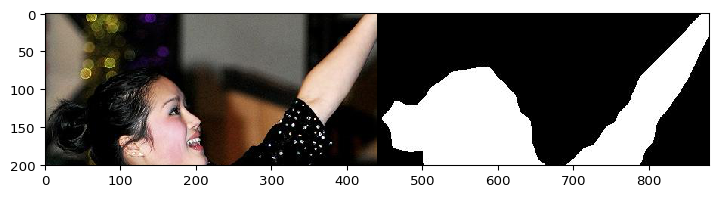

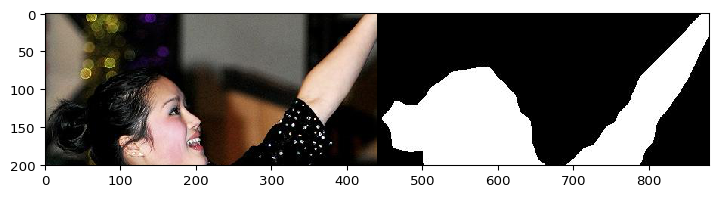

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


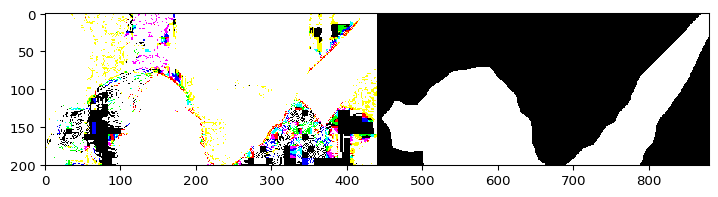

In [290]:
train_datagen.show_sample_image()

In [291]:
val_datagen = DataGenerator(DATA_DIR, [VAL_ANNO_FILE1, VAL_ANNO_FILE2], aug, batch_size=24)

In [292]:
val_datagen.get_n_examples()

600

In [293]:
# val_datagen.label_paths

In [294]:
# show_sample_image(val_datagen.label_paths)

In [295]:
# imutils.resize?

## Training Model

In [296]:
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [297]:
# frotensorflow.no_op.n

In [269]:
class SINetLoss:
    def __init__(self, lamda=0.9):
        self.lamda = lamda
        
    def gt_dilation(self, y_true):
        y_true = tf.reshape(y_true, (-1, IMG_HEIGHT, IMG_WIDTH, N_CLASSES))
        dilation = tf.nn.max_pool2d(y_true, ksize=(15, 15), strides=1, name='dilation2D', padding="SAME")
        dilation = tf.reshape(dilation, (-1, IMG_HEIGHT*IMG_WIDTH, N_CLASSES))
        
        return dilation
    
    def gt_erosion(self, y_true):
        y_true = tf.reshape(y_true, (-1, IMG_HEIGHT, IMG_WIDTH, N_CLASSES))
        erosion = -tf.nn.max_pool2d(-y_true, ksize=(15, 15), strides=1, name='erosion2D', padding="SAME")
        erosion = tf.reshape(erosion, (-1, IMG_HEIGHT*IMG_WIDTH, N_CLASSES))
        
        return erosion
        
    def log_loss(self, y_true, y_pred):
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss
        
    def boundary_loss(self, y_true, y_pred):
        dilation = self.gt_dilation(y_true)
        erosion = self.gt_erosion(y_true)

        boundary = tf.math.subtract(dilation, erosion)
#         boundary = tf.reshape(boundary, (-1, IMG_HEIGHT*IMG_WIDTH, N_CLASSES))
#         assign_indices = tf.count_nonzero(boundary, axis=-1)
#         assign_indices = tf.where(boundary)
#         print(tf.shape(boundary).eval(session=tf.compat.v1.Session()))
#         mask = tf.math.greater(tf.to_float(boundary), tf.constant(0.0))
#         zeros_mask = tf.zeros_like(boundary)
        
#         b_true = tf.where(mask, y_true, zeros_mask)
#         b_pred = tf.where(mask, y_pred, zeros_mask)
        loss = -tf.reduce_sum(boundary * tf.math.log(y_pred), axis=-1)
        
        return loss
    
    def compute_loss(self, y_true, y_pred):
        batch_size = tf.shape(y_pred)[0]
        self.lamda = self.lamda
        log_loss_ = tf.cast(self.log_loss(y_true, y_pred), tf.float32)
        boundary_loss_ = tf.cast(self.boundary_loss(y_true, y_pred), tf.float32)
        total_loss = log_loss_ + self.lamda * boundary_loss_
#         total_loss = tf.cast(total_loss, tf.float32)
        total_loss *= tf.cast(batch_size, tf.float32)
        
        return total_loss

In [270]:
# tf.nn.dilation2d?

In [271]:
sinet_loss = SINetLoss().compute_loss

In [298]:
init_lr = 1e-3

opt = Adam(lr=init_lr, decay=2e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)

In [299]:
model.compile(optimizer=opt, loss=sinet_loss, metrics=["accuracy"])

In [300]:
trained_weight = "trained_weight"

if not os.path.exists(trained_weight):
    os.mkdir(trained_weight)

In [301]:
import keras.backend as K
import keras.callbacks as cbks

In [302]:
class CustomMetrics(cbks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        for k in logs:
            if k.endswith('boundary_loss'):
                print(logs[k])

In [303]:
# checkpoints = ModelCheckpoint(filepath=os.path.join(trained_weight, "best_weights.h5"), 
#                               monitor="val_loss", 
#                               save_weights_only=True,
#                               save_best_only=True,
#                               verbose=1)

In [304]:
model.load_weights("trained_weight/best_weights_1.h5")

In [307]:
checkpoints = ModelCheckpoint(filepath=os.path.join(trained_weight, "best_weights_1_all.h5"), 
                              monitor="val_loss", 
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [309]:
for idx, layer in enumerate(model.layers):
    print(idx, layer.name, layer.trainable)
    
    layer.trainable = True
#     if idx > 360:
#         layer.trainable = False

0 input_1 True
1 swap_color_channel True
2 mean_substraction_inputs True
3 conv_1_pad True
4 conv_1 True
5 conv_1_bn True
6 conv_1_act True
7 conv_pad_2 True
8 conv_dw_2 True
9 conv_dw_2_bn True
10 conv_dw_2_Prelu True
11 conv_pw_2 True
12 conv_pw_2_bn True
13 conv_pw_2_relu True
14 squeeze_glo_avg_2 True
15 squeeze_squ_2 True
16 squeeze_exci_2 True
17 squeeze_scale_2 True
18 activation_1 True
19 conv_pad_3 True
20 conv_dw_3 True
21 conv_dw_3_bn True
22 conv_dw_3_Prelu True
23 conv_pw_3 True
24 conv_pw_3_bn True
25 conv_pw_3_relu True
26 squeeze_glo_avg_3 True
27 squeeze_squ_3 True
28 squeeze_exci_3 True
29 squeeze_scale_3 True
30 activation_2 True
31 conv_4 True
32 conv_4_bn True
33 conv_4_act True
34 average_pooling2d_1 True
35 average_pooling2d_2 True
36 activation_3 True
37 activation_5 True
38 conv_pad_4_1 True
39 conv_pad_4_2 True
40 conv_dw_4_1 True
41 conv_dw_4_2 True
42 conv_dw_4_1_bn True
43 conv_dw_4_2_bn True
44 conv_dw_4_1_Prelu True
45 conv_dw_4_2_Prelu True
46 conv_pw_4_

In [310]:
# !rm -rf "trained_weight/best_weights.h5"

In [ ]:
H = model.fit_generator(train_datagen.generate(),
                        epochs=100,
                        steps_per_epoch=train_datagen.get_n_examples() // train_datagen.batch_size,
                        validation_data=val_datagen.generate(),
                        validation_steps=val_datagen.get_n_examples() // val_datagen.batch_size,
                        callbacks=[checkpoints],
                        initial_epoch=34
                        )

Epoch 35/100
149/423 [=========>....................] - ETA: 5:52 - loss: 8.3127 - accuracy: 0.9678

## Predictions

In [312]:
model.load_weights("trained_weight/best_weights_1_all.h5")

In [313]:
def predict():
    idx = np.random.choice(val_datagen.get_n_examples(), 1)[0]
    img_path = val_datagen.image_paths[idx]
    label_path = val_datagen.label_paths[idx]
    
    preprocessors = [val_datagen.resize_img, val_datagen.mean_substraction]
    img_origin = val_datagen.load_image(img_path)
    label = val_datagen.load_image(label_path)
    label = val_datagen.resize_img(label, interpolation=cv2.INTER_NEAREST)
    img_preprocess = val_datagen.preprocessing(img_origin, preprocessors=preprocessors)
    img = np.expand_dims(img_preprocess, axis=0)
    
    prediction = model.predict(img)
    prediction = prediction[0]
    mask = np.reshape(prediction, (IMG_HEIGHT, IMG_WIDTH, N_CLASSES))
    mask = np.argmax(mask, axis=-1)
    mask[mask > 0] = 255
    
#     print(mask)
#     for i in range(N_CLASSES):
#     class_idx = prediction.argmax(axis=-1)
    mask = cv2.merge([mask, mask, mask])
    
    ia.imshow(np.hstack([
        img_preprocess,
        mask
    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


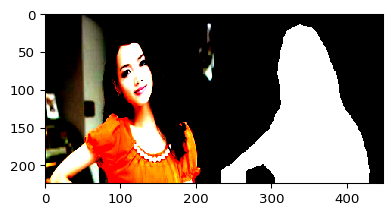

In [329]:
predict()